In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
data = np.load("data/DK_time_series_3000000.npy")

train = data[:-500000]
test =  data[-500000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

Text(0.5, 0, 't')

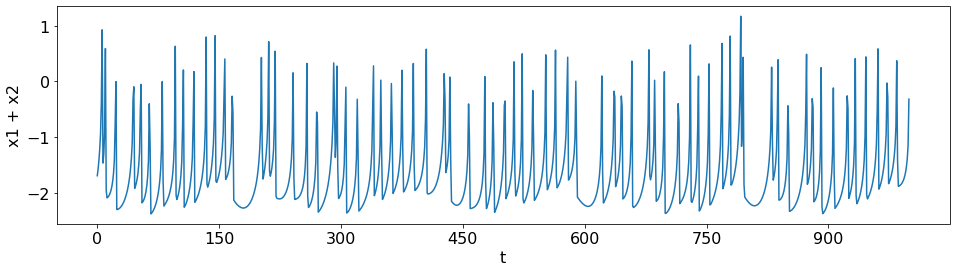

In [4]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(data[1000:2000])

#ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title("RMSE",  fontsize = 16)
ax.set_ylabel("x1 + x2",  fontsize = 16)
ax.set_xlabel("t",  fontsize = 16)

# plt.figure(figsize=(16, 9))




In [3]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans        
    

In [4]:
def one_hot(x, num_channels=256, device='cuda'):
    x_o = torch.FloatTensor(x.shape[0], num_channels, x.shape[1])
    x_o = x_o.to(device)
    x_o.zero_().scatter_(1, x.unsqueeze(1), 1)
    return x_o

In [5]:
int_data = amp_to_int(data)
train = int_data[:-500000]
test = int_data[-500000:]

In [8]:
lstm_predicts = np.load("./predictions/lstm_predicts_as_bin.npy")

In [9]:
def CalcRMSE(x, y):
    return (((x - y)**2).mean())**0.5

In [10]:
test_right_part = (len(test)- 20)%64

In [17]:
lstm_rmses = []
lstm_rmses.append(CalcRMSE(int_to_amp(lstm_predicts[0][1:], data), test[20:-test_right_part]))
for i in tqdm(range(1, 19)):
    lstm_rmses.append(CalcRMSE(int_to_amp(lstm_predicts[i][1:], data, n=256)[:-i], test[20+i: -test_right_part]))

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 107.84it/s]


In [13]:
rmse_chaos = np.load("predictions/lstm_rmse.npy")
wave_net_predicts = np.load("predictions/wavenet_predict_all_steps.npy")
wavenet_rmses = []
for i in tqdm(range(19)):
    wavenet_rmses.append(CalcRMSE(int_to_amp(wave_net_predicts[:, 1:][i], data, n=256)[:-1-i], data[-499999 + i:]))

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 104.73it/s]


In [20]:
wave_net_predicts_cont = np.load("predictions/wavenet_predict_all_steps_cont.npy")
wavenet_rmses_cont = []
for i in tqdm(range(19)):
    wavenet_rmses_cont.append(CalcRMSE(wave_net_predicts_cont[:, 1:][i][:-1-i], data[-499999 + i:]))

100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 361.78it/s]


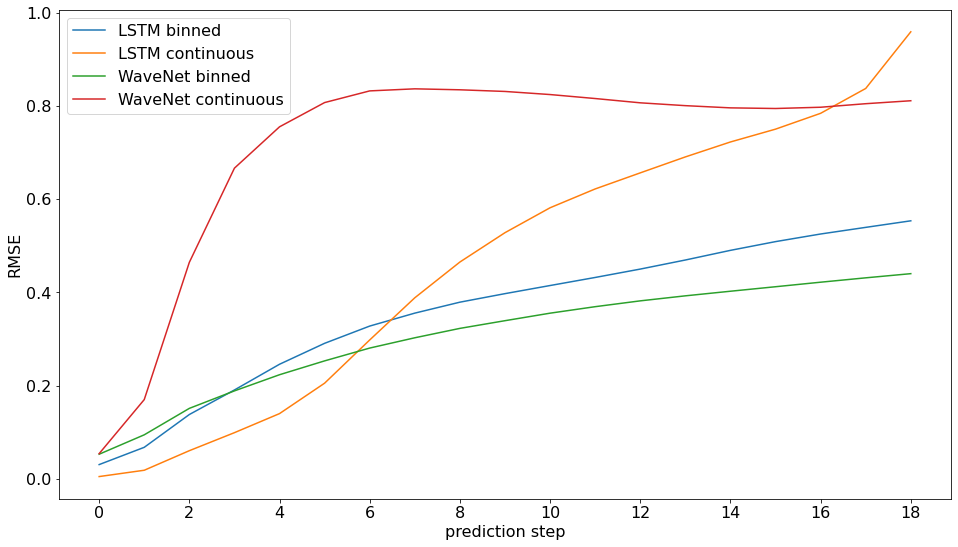

<Figure size 1152x648 with 0 Axes>

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.plot(lstm_rmses, label="LSTM binned")
ax.plot(rmse_chaos, label="LSTM continuous")
ax.plot(wavenet_rmses, label="WaveNet binned")
ax.plot(wavenet_rmses_cont, label="WaveNet continuous")

#ax.legend()
ax.tick_params(axis='both', which='major', labelsize=16)
#ax.set_title("RMSE",  fontsize = 16)
ax.set_ylabel("RMSE",  fontsize = 16)
ax.set_xlabel("prediction step",  fontsize = 16)

# plt.figure(figsize=(16, 9))


ax.legend(fontsize = 16)